# $$\text{WEATHER - BOSTON}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [1198]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acovf
import statsmodels.api as sm

In [1199]:
from scipy.stats import ttest_1samp, levene, shapiro, jarque_bera, norm
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [1200]:
# BOSTON
data = pd.read_csv('boston.csv')
data['time'] = pd.to_datetime(data['time'])
data.isnull().sum()

time      0
tavg      1
tmin      0
tmax      0
prcp      0
wdir    587
wspd      0
pres    161
dtype: int64

- uzupełnienie braków - średnia temperatura z dnia poprzedniego i dnia następnego

In [1201]:
data['tavg'] = data['tavg'].replace('', np.nan)
missing_index = data[data['tavg'].isnull()].index[0]

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,NaN,-2.2,2.8,0.0,NaN,12.6,NaN


In [1202]:
prev_day = data['tavg'].iloc[missing_index - 1]
next_day = data['tavg'].iloc[missing_index + 1]
data.at[missing_index, 'tavg'] = (prev_day + next_day) / 2

data.head(missing_index+1)

,time,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2013-03-01,3.2,1.1,5.0,0.0,342.0,15.1,1002.7
1,2013-03-02,3.1,1.1,5.6,0.0,307.0,14.4,1004.2
2,2013-03-03,2.6,0.6,6.1,0.0,NaN,14.4,1002.6
3,2013-03-04,1.8,-0.6,5.0,0.0,303.0,28.1,1003.0
4,2013-03-05,2.9,0.0,6.1,0.0,NaN,16.6,1013.5
5,2013-03-06,3.2,1.7,5.0,1.3,58.0,36.7,1018.5
6,2013-03-07,0.4,-1.1,2.8,11.7,20.0,38.2,1016.5
7,2013-03-08,0.4,-2.2,5.6,23.9,9.0,29.5,1016.3
8,2013-03-09,1.8,-0.6,3.3,0.0,35.0,17.6,1024.3
9,2013-03-10,3.3,-2.2,2.8,0.0,NaN,12.6,NaN


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2013-03-01 do 2023-03-01 (tzn. 'równe oddalenie w czasie')?

In [1203]:
data_copy = data.copy()

In [1204]:
#BOSTON
data_copy['time'] = pd.to_datetime(data_copy['time'])
data_copy.set_index('time', inplace=True)
data_copy.sort_index(inplace=True)

In [1205]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

In [1206]:
#BOSTON
data_selected = data[['time', 'tavg']]
temp = data_selected['tavg']
time = data_selected['time']
data_selected.head()

,time,tavg
0,2013-03-01,3.2
1,2013-03-02,3.1
2,2013-03-03,2.6
3,2013-03-04,1.8
4,2013-03-05,2.9


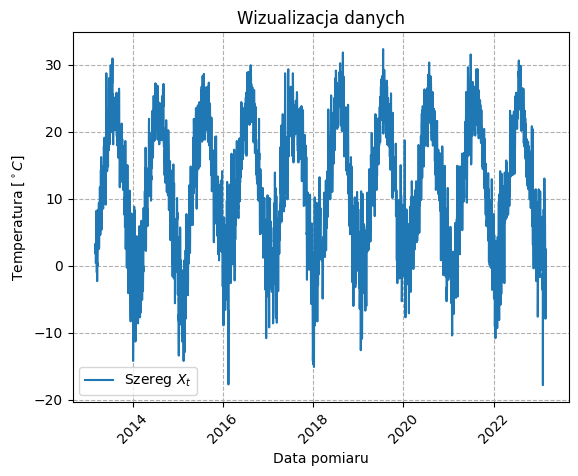

In [1207]:
plt.plot(time, temp, label = 'Szereg $X_t$')
plt.grid(True, linestyle = '--')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xlabel('Data pomiaru')
plt.xticks(rotation = 45)
plt.legend()
plt.title("Wizualizacja danych")
plt.savefig('Temperature_data.png', bbox_inches='tight')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [1208]:
# minimalna i maksymalna prędkość wiatru
min_temp = np.min(temp)
max_temp = np.max(temp)

print('Minimalna prędkość wiatru w danych:', min_temp)
print('Maksymalna prędkość wiatru w danych:', max_temp)

Minimalna prędkość wiatru w danych: -17.8
Maksymalna prędkość wiatru w danych: 32.3


    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych - EMPIRYCZNIE

In [1209]:
def autokowariancja_emp(x, h):
    n = len(x)
    autocov = np.zeros(len(h))
    for j, hi in enumerate(h):
        if hi < n:
            autocov[j] = (1 / n) * np.sum((x[:n - hi] - np.mean(x)) * (x[hi:] - np.mean(x)))
        else:
            autocov[j] = 0
    return autocov

In [1210]:
def autokorelacja_emp(x, h):
    autocov = autokowariancja_emp(x, h)
    autocov_0 = autocov[0] 
    autokor = autocov / autocov_0
    return autokor

In [1211]:
def partialautocor(x, h):
    gamma_hat = autokowariancja_emp(x, h)
    pacf = np.zeros(len(h))
    pacf[0] = 1.0 
    for k in range(1, len(h)):
        gamma_matrix = np.array([[gamma_hat[abs(i - j)] for j in range(k)] for i in range(k)])
        gamma_vector = gamma_hat[1 : k + 1]
        phi_k = np.linalg.solve(gamma_matrix, gamma_vector)
        pacf[k] = phi_k[-1]
    return pacf

In [1212]:
Xt = temp.values
h = 40

In [1213]:
h_range = np.arange(h+1)
ACF_emp = autokorelacja_emp(x = Xt, h = h_range)
PACF_emp = partialautocor(x = Xt, h = h_range)

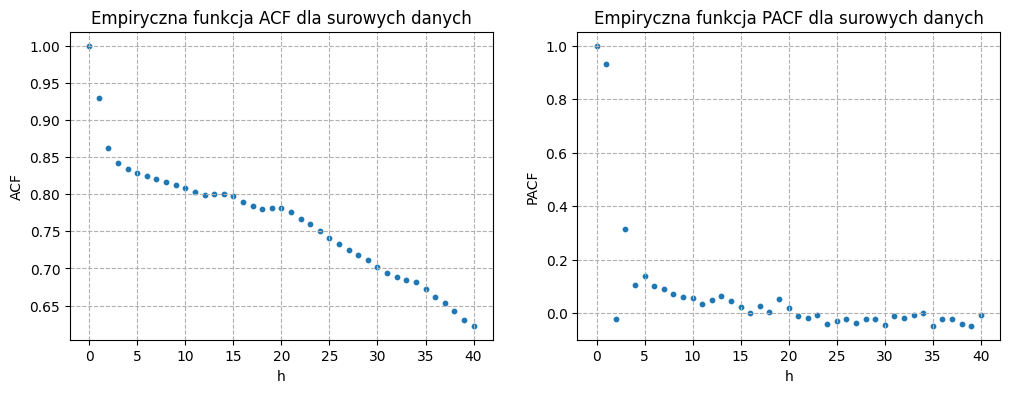

In [1214]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(h_range, ACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja ACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('ACF')

plt.subplot(1,2,2)
plt.scatter(h_range, PACF_emp, s=10)
plt.grid(True, linestyle = '--')
plt.title('Empiryczna funkcja PACF dla surowych danych')
plt.xlabel('h')
plt.ylabel('PACF')


plt.show()

-  wykres ACF oraz PACF dla surowych danych - WBUDOWANA FUNKCJA (statsmodels)

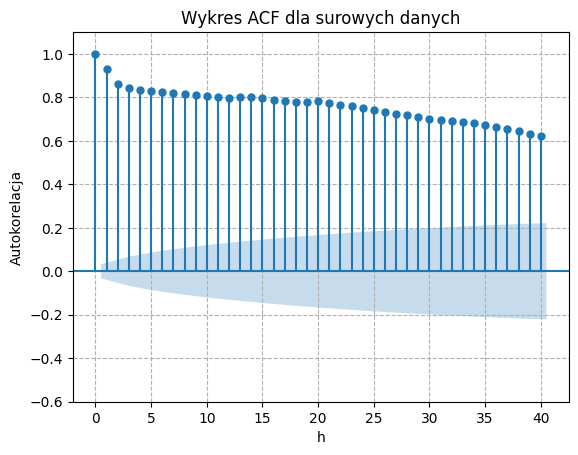

In [1215]:
plot_acf(Xt, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.6,1.1)

plt.savefig('ACF_raw_data.png', bbox_inches='tight')
plt.show()

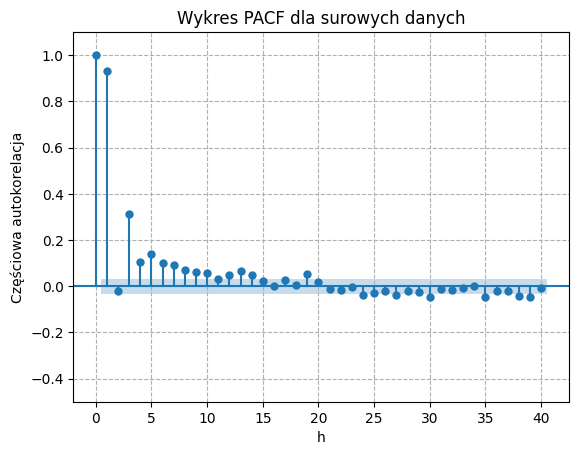

In [1216]:
plot_pacf(Xt, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_raw_data.png', bbox_inches='tight')
plt.show()


    2.3. (*opcjonalne) Testowanie stacjonarności - surowe dane

In [1217]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [1218]:
is_Xt_stationary = adfuller_test(Xt)
is_Xt_stationary

Statystyka testowa = -3.601, p-Value = 0.006 => Stationary. 


    2.4. Identyfikacja trendów deterministycznych

$$ X_t = m(t) + s(t) + Y(t)  $$

- trend m(t)

In [1219]:
n = len(Xt)
t = np.linspace(0, n, n)
m_fit = np.polyfit(t, Xt, 1)
mt = np.polyval(m_fit, t)

In [1220]:
Xt_without_trend = Xt - mt

- sezonowość s(t)

In [1221]:
def s_func_para(t, a, b, c):
    return a*np.sin(b*t + c)

In [1222]:
a_initial = (np.max(Xt) - np.min(Xt)) / 2
b_initial = 2 * np.pi / 365
c_initial = np.pi/2
d_initial = np.mean(Xt)

params, covariance = curve_fit(s_func_para, t, Xt_without_trend, p0=[a_initial, b_initial, c_initial])

a_fit, b_fit, c_fit = params
st = s_func_para(t, a_fit, b_fit, c_fit)

In [1223]:
params

array([-12.19793189,   0.01720239,   2.13821696])

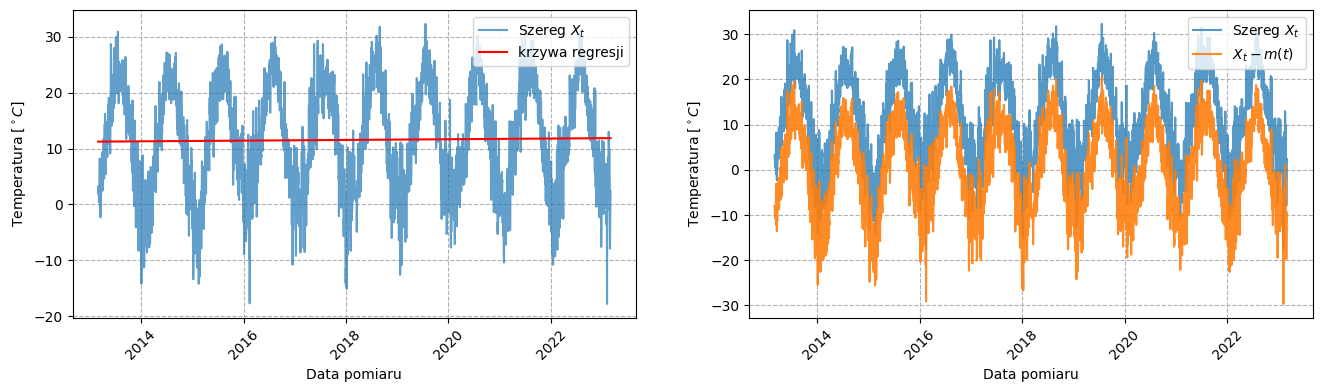

In [1224]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(time, Xt, alpha = 0.7, label = 'Szereg $X_t$')
plt.plot(time, mt, color = 'red', label = 'krzywa regresji')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.subplot(1,2,2)
plt.plot(time, Xt, alpha = 0.75, label = 'Szereg $X_t$')
plt.plot(time, Xt_without_trend, alpha = 0.9, label = '$X_t - m(t)$')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('Xt_without_trend.png', bbox_inches='tight')
plt.show()

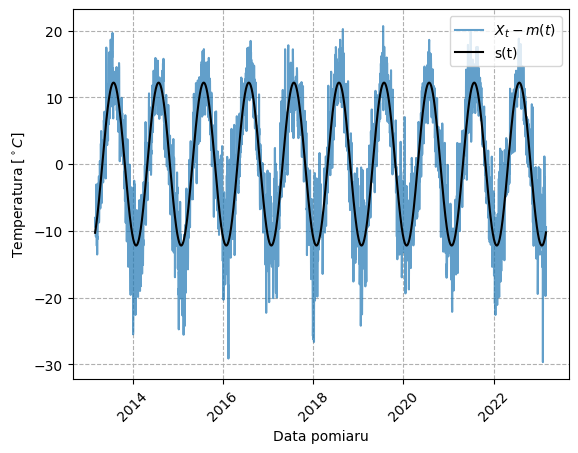

In [1225]:
plt.plot(time, Xt_without_trend, alpha = 0.7, label = '$X_t - m(t) $')
plt.plot(time, st, color = 'black', label = 's(t)')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.grid(True, linestyle='--')

plt.savefig('Xt_seasonal.png', bbox_inches='tight')
plt.show()

- Szereg czasowy liniowy $Y_t$

In [1226]:
Yt = Xt - mt - st

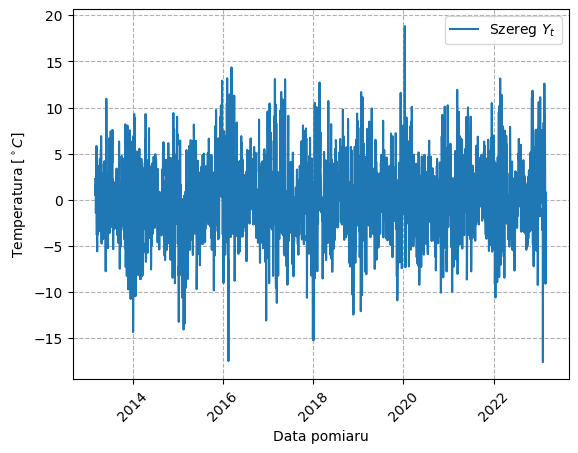

In [1227]:
plt.plot(time, Yt, label = 'Szereg $Y_t$')
plt.grid(True, linestyle='--')
plt.xlabel('Data pomiaru')
plt.ylabel('Temperatura [$^\\circ C$]')
plt.xticks(rotation = 45)
plt.legend()

plt.savefig('cleanYt.png', bbox_inches='tight')
plt.show()

    2.5. Wykres ACF oraz PACF dla uzyskanego szeregu

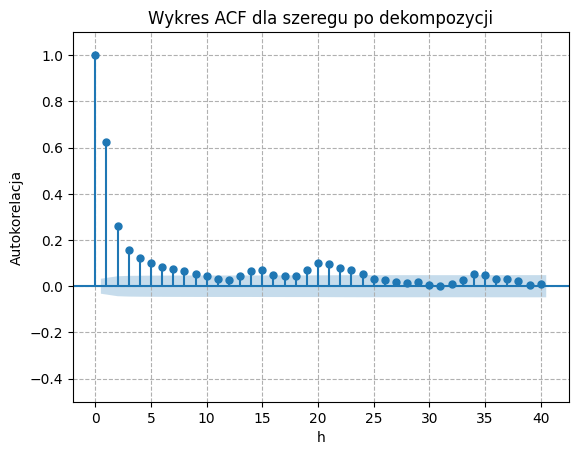

In [1228]:
plot_acf(Yt, lags=h)
plt.title("Wykres ACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('Autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('ACF_data.png', bbox_inches='tight')
plt.show()

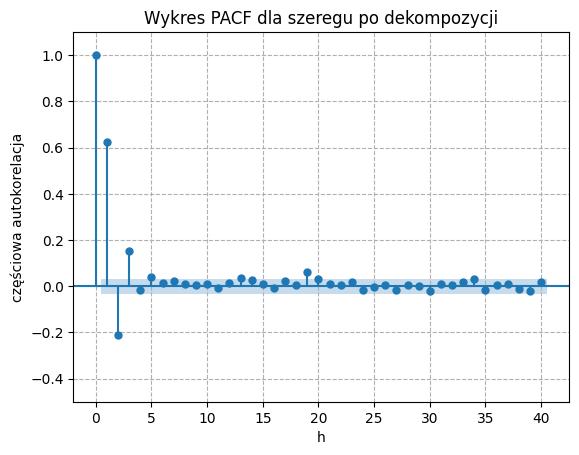

In [1229]:
#zmiana: w plot_pacf podany był szereg Xt (sprzed dekompozycji)
plot_pacf(Yt, lags=h, method='ywm')
plt.title("Wykres PACF dla szeregu po dekompozycji")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-0.5,1.1)

plt.savefig('PACF_data.png', bbox_inches='tight')
plt.show()


    2.6. (*opcjonalne) Testowanie stacjonarności - po dekompozycji

In [1230]:
is_Yt_stationary = adfuller_test(Yt)
is_Yt_stationary

Statystyka testowa = -10.159, p-Value = 0.0 => Stationary. 


## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

In [1231]:
p_values = []
q_values = []
BIC = []
AIC = []
HQIC = []
df = pd.DataFrame()

max_p = 4
max_q = 4

for p in range(0, max_p):
    for q in range(0, max_q):
        
        arima_model = ARIMA(Yt, order=(p, 0, q))
        arima_model_fit = arima_model.fit()
        
        p_values.append(p)
        q_values.append(q)
        AIC.append(arima_model_fit.aic)
        BIC.append(arima_model_fit.bic)
        HQIC.append(arima_model_fit.hqic)

df['p'] = p_values
df['q'] = q_values
df['AIC'] = AIC
df['BIC'] = BIC
df['HQIC'] = HQIC


In [1232]:
#posortowanie wartości wg wartości AIC (od najmniejszej)
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467
15,3,3,18641.539307,18691.165740,18659.211899
7,1,3,18642.573640,18679.793464,18655.828084


In [1233]:
#posortowanie wartości wg wartości BIC (od najmniejszej)
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
7,1,3,18642.573640,18679.793464,18655.828084
12,3,0,18650.986950,18682.003470,18662.032320
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467


In [1234]:
#posortowanie wartości wg wartości HQIC (od najmniejszej)
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
10,2,2,18637.794062,18675.013886,18651.048506
11,2,3,18639.793912,18683.217040,18655.257430
14,3,2,18639.793949,18683.217077,18655.257467
7,1,3,18642.573640,18679.793464,18655.828084
15,3,3,18641.539307,18691.165740,18659.211899


In [1235]:
# krótka analiza dla wybranego modelu
p = 2
q = 2

fitted_model = ARIMA(Yt, order=(p, 0, q)).fit(method='innovations_mle')
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -9312.897
Date:                Mon, 27 Jan 2025   AIC                          18637.794
Time:                        10:50:26   BIC                          18675.014
Sample:                             0   HQIC                         18651.049
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.180      0.047      0.963      -0.344       0.361
ar.L1          1.2533      0.043     29.048      0.000       1.169       1.338
ar.L2         -0.2879      0.030     -9.488      0.0

    3.2. Estymacja parametrów modelu wybraną metodą.

In [1236]:
#estymacja współczynników phi modelu AR(p) metodą Yule-Walkera

def yule_walker_estimation(data, p):
    data_centered = data - np.mean(data)
    autocovariance = acovf(data_centered, fft=True)[:p+1]
    Gamma = np.array([[autocovariance[abs(i - j)] for j in range(p)] for i in range(p)])
    acovf_array = autocovariance[1:p+1]
    phi_vector = np.linalg.solve(Gamma, acovf_array)
    
    return phi_vector

In [1237]:
phi_1, phi_2 = yule_walker_estimation(Yt, 2)
print("Współczynnik phi_1 = ", phi_1, ", współczynnik phi_2 = ", phi_2)

Współczynnik phi_1 =  0.7559664120339147 , współczynnik phi_2 =  -0.21043588585930634


##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

    4.2. Porównanie linii kwantylowych z trajektorią

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

a) wykres wartości resztowych

In [1238]:
# residua
residuals = fitted_model.resid

array([ 1.25331363, -0.28793006, -0.46538458, -0.41412933])

In [1239]:
np.max(residuals)

np.float64(12.091313593069746)

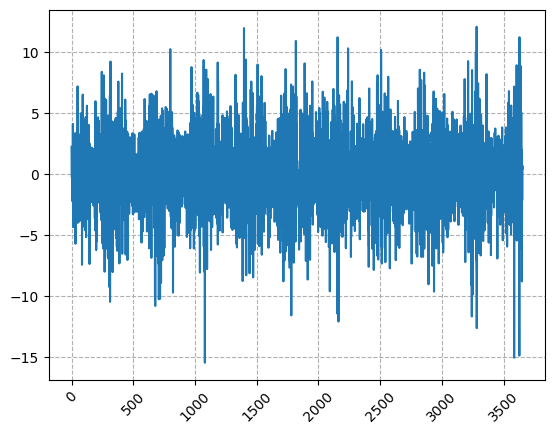

In [1240]:
plt.plot(residuals)
plt.grid(True, linestyle='--')
plt.xticks(rotation = 45)

plt.savefig('residua.png', bbox_inches='tight')
plt.show()

b) t test

$H_0: \bar{x} = 0$

$H_1: \bar{x} \neq 0$

In [1241]:
def t_test(Xt, mean_value, confidence_level):
    t_stat, p_value = ttest_1samp(Xt, mean_value)
    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {t_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {t_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [1242]:
t_test(residuals , mean_value = 0, confidence_level = 0.95)

Statystyka testowa = -0.012047428365211357, p-Value = 0.9903884334832664 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


In [1243]:
mu_residuals = np.mean(residuals)
mu_residuals

np.float64(-0.0006173727624182841)

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

a) wykres wartości resztowych

b) Test Levene’a jednorodności wariancji

$H_0: \sigma = \sigma_0$

$H_1: \sigma \neq \sigma_0$

In [1244]:
def levene_test(Xt, confidence_level):
    levene_stat, p_value = levene(Xt[:len(Xt)//2], Xt[len(Xt)//2:])
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {levene_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [1245]:
levene_test(residuals, confidence_level=0.95)

Statystyka testowa = 1.0268451658146034, p-Value = 0.3109679492477704 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


In [1246]:
var_residuals = np.var(residuals)

c) Test ARCH

In [1247]:
def arch_test(Xt, confidence_level):
    arch_stat, p_value, _, _ = het_arch(Xt)
    if p_value < 1-confidence_level:
        print(f"Statystyka testowa = {arch_stat}, p-Value = {p_value} < {1- confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {arch_stat}, p-Value = {p_value} >= {1- confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [1248]:
arch_test(residuals, confidence_level=0.95)

Statystyka testowa = 149.7460716259246, p-Value = 4.2039039307921695e-27 < 0.050000000000000044 => Odrzucono hipotezę zerową.


    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

b) Test Ljunga-Boxa

$H_0:$ dane są nieskorelowane

$H_1:$ dane są skorelowane

In [1249]:
def LB_test(Xt, confidence_level):
    LB_result = acorr_ljungbox(Xt, lags=[10], return_df=True)  #
    LB_stat = LB_result['lb_stat'].iloc[0]
    p_value = LB_result['lb_pvalue'].iloc[0]

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {LB_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {LB_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [1250]:
LB_test(residuals, confidence_level=  0.95)

Statystyka testowa = 1.7926, p-Value = 0.9977 >= 0.050000000000000044 => Nie można odrzucić hipotezy zerowej.


    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

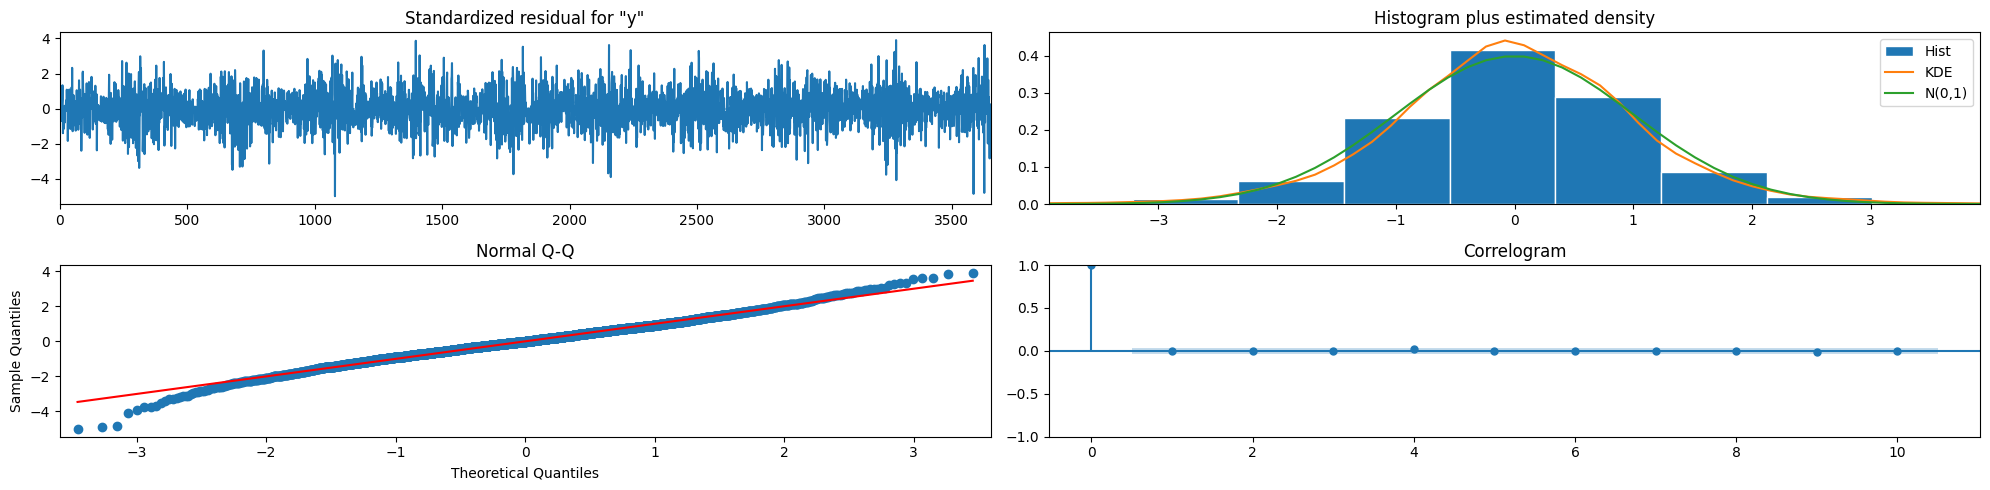

In [1251]:
fitted_model.plot_diagnostics(0,figsize=(20,5))
plt.tight_layout()
plt.show()

In [1252]:
xs = np.linspace(np.min(residuals), np.max(residuals), 1000)
f_normal = norm.pdf(xs, mu_residuals, np.sqrt(var_residuals))
F_normal = norm.cdf(xs, mu_residuals, np.sqrt(var_residuals))

- dystrybuanta

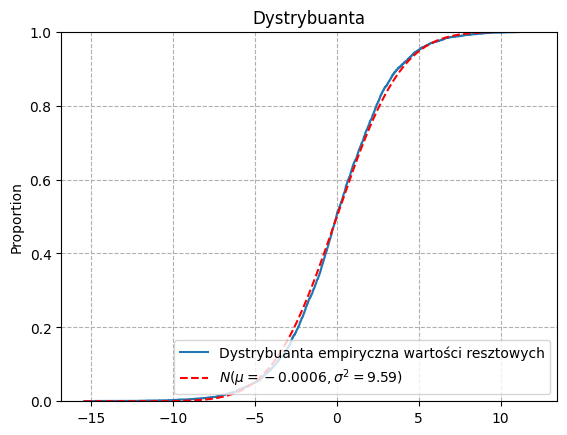

In [1253]:
sns.ecdfplot(residuals, label = "Dystrybuanta empiryczna wartości resztowych")
plt.plot(xs, F_normal, 'r--', label = f'$N(\\mu = {mu_residuals:.4f}, \\sigma^2 = {var_residuals:.2f})$')
plt.grid(True, linestyle='--')
plt.legend(loc='lower right')
plt.title('Dystrybuanta')
plt.show()

- gęstość

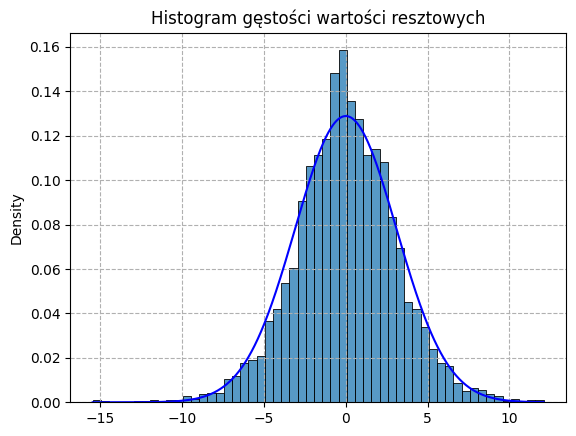

In [1254]:
sns.histplot(residuals, stat="density", label = 'Gęstość wartości resztowych')
plt.plot(xs, f_normal, 'b', label = f'$N(\\mu = {mu_residuals:.4f}, \\sigma^2 = {var_residuals:.2f})$')
plt.title("Histogram gęstości wartości resztowych")
plt.grid(True, linestyle='--')
plt.show()

- Wykres kwantylowy

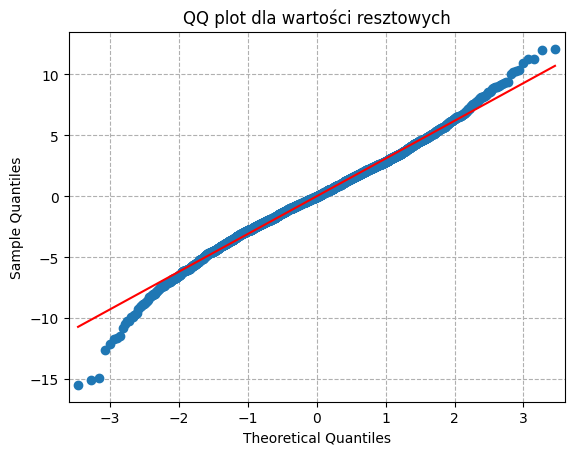

In [1255]:
# QQ plot
sm.qqplot(residuals, line="s")
plt.title("QQ plot dla wartości resztowych")
plt.grid(True, linestyle = '--')
plt.show()

- Testy na normalność

a) Test Shapiro-Wilka

$H_0$: Próba pochodzi z populacji o rozkładzie normalnym

$H_1$: Próba nie pochodzi z populacji o rozkładzie normalnym

In [1256]:
def shapiro_test(Xt, confidence_level):
    shapiro_stat, p_value = shapiro(Xt)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {shapiro_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {shapiro_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [1257]:
shapiro_test(residuals, confidence_level=0.95)

Statystyka testowa = 0.9922, p-Value = 0.0000 < 0.050000000000000044 => Odrzucono hipotezę zerową.


b) Test Jarque-Bera - oparty na miarach skośności i kurtozy rozkładu badanej zmiennej. 

$H_0$: normalność badanego rozkładu

$H_1$: brak normalności badanego rozkładu

In [1258]:
def JB_test(Xt, confidence_level):
    JB_stat, p_value = jarque_bera(Xt)

    if p_value < 1 - confidence_level:
        print(f"Statystyka testowa = {JB_stat:.4f}, p-Value = {p_value:.4f} < {1 - confidence_level} => Odrzucono hipotezę zerową.")
    else:
        print(f"Statystyka testowa = {JB_stat:.4f}, p-Value = {p_value:.4f} >= {1 - confidence_level} => Nie można odrzucić hipotezy zerowej.")

In [1259]:
JB_test(residuals, confidence_level=0.95)

Statystyka testowa = 191.6389, p-Value = 0.0000 < 0.050000000000000044 => Odrzucono hipotezę zerową.


## 6. Podsumowanie